# Data Prep Process

## Load Data

You should now have access to **three datasets** (`demographics.csv`, `behavioral_metrics.csv`, `survey_scores.csv`). Treat these as if they came from three different information systems. Do all of your work in this notebook.

Organize your work into clearly labeled sections.

#### 1. Data loading and initial inspection

1. Load all three datasets into pandas DataFrames.
2. For each dataset:

   * Display the first few rows.
   * Report the number of rows and columns.
   * List column names and data types.
   * Briefly describe, in your own words, what each dataset appears to represent.

#### 2. Data merging

1. Identify potential keys or combinations of columns that could be used to **link** the datasets.
2. Engineer any necessary join keys.
3. Merge the three datasets into a single modeling table.
4. Clearly document:

   * Your merging strategy (which keys, which type of joins).
   * How you handled unmatched rows and duplicates.
   * Any assumptions you made.

### Behavioral Metrics Dataset

* Explain here what this dataset is trying to represent

In [8]:
import os
import pandas as pd



behavioral_metrics_df = pd.read_csv('../data/behavioral_metrics.csv')
print(behavioral_metrics_df.shape)
print(behavioral_metrics_df.info())
print(behavioral_metrics_df.head())

(1010, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   informative_1        1010 non-null   float64
 1   informative_2        1010 non-null   float64
 2   target               1010 non-null   float64
 3   class                1010 non-null   int64  
 4   corr_feature_class   960 non-null    float64
 5   multicollinearity 1  505 non-null    float64
 6   multicollinearity 2  708 non-null    float64
 7   multicollinearity 3  910 non-null    float64
 8   multicollinearity 4  808 non-null    float64
 9   uniform corr 1       960 non-null    float64
 10  uniform corr 2       958 non-null    float64
 11  outliers 1           909 non-null    float64
 12  outliers 2           1010 non-null   float64
 13  standard scaling     959 non-null    float64
 14  min max scaling      960 non-null    float64
 15  login_id             954 no

### Demographics Dataset

* Explain here what this dataset is trying to represent

In [9]:
demographics_df = pd.read_csv('../data/demographics.csv')
print(demographics_df.shape)
print(demographics_df.info())
print(demographics_df.head())

(1010, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   given_name       506 non-null    object 
 1   surname          808 non-null    object 
 2   binary           773 non-null    object 
 3   date_of_birth    959 non-null    object 
 4   day_of_week      908 non-null    object 
 5   email            1010 non-null   object 
 6   phone_number     808 non-null    object 
 7   address          454 non-null    object 
 8   city             638 non-null    object 
 9   state            457 non-null    object 
 10  zipcode          725 non-null    float64
 11  semi_constant_1  1010 non-null   object 
 12  semi_constant_2  1010 non-null   object 
dtypes: float64(1), object(12)
memory usage: 102.7+ KB
None
  given_name   surname    binary date_of_birth day_of_week  \
0      Erika     Davis  binary_1    2022-02-24    Saturday   
1      E

### Survey Scores Dataset

* Explain here what this dataset is trying to represent

In [10]:
survey_scores_df = pd.read_csv('../data/survey_scores.csv')
print(survey_scores_df.shape)
print(survey_scores_df.info())
print(survey_scores_df.head())

(1030, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pd qcut1            1030 non-null   object 
 1   pd qcut2            716 non-null    object 
 2   pd qcut3            925 non-null    object 
 3   random choice 2     723 non-null    object 
 4   random choice 4     1030 non-null   object 
 5   random choice 7     979 non-null    object 
 6   random label num 4  721 non-null    object 
 7   semi_constant_1     1030 non-null   object 
 8   semi_constant_2     1030 non-null   object 
 9   contact_phone       826 non-null    float64
dtypes: float64(1), object(9)
memory usage: 80.6+ KB
None
  pd qcut1 pd qcut2 pd qcut3 random choice 2 random choice 4 random choice 7  \
0     High       Q3       G5             NaN            West         Tuesday   
1     High       Q3      NaN   Rand Choice 2            East          Monday

## Merge the Datasets

#### Data merging

1. Identify potential keys or combinations of columns that could be used to **link** the datasets.
2. Engineer any necessary join keys.
3. Merge the three datasets into a single modeling table.
4. Clearly document:

   * Your merging strategy (which keys, which type of joins).
   * How you handled unmatched rows and duplicates.
   * Any assumptions you made.

###Merging strategy

I used behavioral_metrics.csv as the base table because it contains the target variable (class) for modeling.

To link demographics and behavioral metrics, I engineered an email-username key:

In demographics, I extracted the username from email (text before @) and standardized to lowercase as login_id.

In behavioral metrics, the same username had already been created as login_id.

To link demographics and survey scores, I used phone-based keys:

In demographics, I extracted the last 7 digits of phone_number into contact_phone.

The survey data already stored this as contact_phone.

###Join types

behavioral_metrics ⟵(left join)⟶ demographics on login_id

result ⟵(left join)⟶ survey_scores on contact_phone
Left joins were chosen so that I keep all behavioral records (the modeling base) even if demographics or survey information is missing.

###Unmatched rows and duplicates

Unmatched demographic rows (e.g., missing login_id or email) result in NaN for those attributes but the behavioral row is kept.

Unmatched survey rows are effectively dropped by the left join, but no behavioral rows are removed.

I dropped exact duplicate rows from the survey dataset before merging.

###Assumptions

login_id and contact_phone were intentionally constructed as join keys by the data generator and are safe to use.

Behavioral data is treated as the “source of truth” for the target, so it should not be filtered out during merging.

Missing joined information represents unavailable data across systems, not an error in the generation process.

In [11]:
# =========================
# ENGINEER JOIN KEYS
# =========================

# --- Email username key for demographics (to match behavioral.login_id)
demographics_df["login_id"] = (
    demographics_df["email"]
        .astype(str)
        .str.extract(r"(^[^@]+)", expand=False)
        .str.lower()
        .str.strip()
)

# --- Last 7 digits of phone for demographics (to match survey.contact_phone)
demographics_df["contact_phone"] = (
    demographics_df["phone_number"]
        .astype(str)
        .str.replace(r"\D", "", regex=True)
        .str[-7:]
)

# Survey already has contact_phone created in the generator script
# Just make sure it's string
survey_scores_df["contact_phone"] = survey_scores_df["contact_phone"].astype(str)

# Behavioral already has login_id created in the generator script
behavioral_metrics_df["login_id"] = behavioral_metrics_df["login_id"].astype(str)

In [12]:
# =========================
# HANDLE SURVEY DUPLICATES
# =========================

# Survey was intentionally given duplicate rows. Drop exact duplicates.
survey_scores_df = survey_scores_df.drop_duplicates().reset_index(drop=True)
print("Survey shape after dropping duplicates:", survey_scores_df.shape)

Survey shape after dropping duplicates: (993, 10)


In [13]:
# =========================
# MERGE BEHAVIORAL + DEMOGRAPHICS
# =========================
# Behavioral is our base table because it contains the target `class`.

merged = behavioral_metrics_df.merge(
    demographics_df,
    on="login_id",
    how="left",
    validate="many_to_many"
)


print("After merging behavioral + demographics:", merged.shape)

After merging behavioral + demographics: (1034, 30)


In [14]:
# =========================
# MERGE SURVEY
# =========================

merged = merged.merge(
    survey_scores_df,
    on="contact_phone",
    how="left",
    validate="many_to_many"
)



print("After merging survey:", merged.shape)

# Quick peek
merged.head()

After merging survey: (1034, 39)


,informative_1,informative_2,target,class,corr_feature_class,multicollinearity 1,multicollinearity 2,multicollinearity 3,multicollinearity 4,uniform corr 1,...,contact_phone,pd qcut1,pd qcut2,pd qcut3,random choice 2,random choice 4,random choice 7,random label num 4,semi_constant_1_y,semi_constant_2_y
0,-0.599991,0.778707,1.712702,1,4.927429,-0.390872,-0.568877,-1.004663,-0.649433,0.543979,...,6793225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.599991,0.778707,1.712702,1,4.927429,-0.390872,-0.568877,-1.004663,-0.649433,0.543979,...,6793225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.778547,1.121791,2.007978,0,-0.051430,-0.157954,NaN,-0.629351,NaN,0.628802,...,6010851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.778547,1.121791,2.007978,0,-0.051430,-0.157954,NaN,-0.629351,NaN,0.628802,...,6010851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.091996,-0.227711,-0.707869,0,0.751865,NaN,1.922281,0.106493,-0.237215,0.306757,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Types and Characteristics of Data

**Numerical Data**

This refers to columns with a numerical data type, typically integers (`int64`) or floating-point numbers (`float64`). These data represent quantities and are used for mathematical operations.

* **Characteristics**:
    * **Continuous**: Can take any value within a given range (e.g., height, temperature, price).
    * **Discrete**: Can only take specific, distinct values (e.g., number of children, counts).
    * **Order**: The values have a meaningful order and can be compared (e.g., 10 is greater than 5).
    * **Mathematical Operations**: Can be used for calculations like mean, standard deviation, and regression analysis.

**Object/String Data**

This refers to columns with an `object` data type, which in pandas often means they contain text or strings. These are non-numeric and don't have inherent mathematical properties.

* **Characteristics**:
    * **Nominal**: Categories without a meaningful order (e.g., colors like "red," "blue," "green").
    * **Textual**: Contains free-form text, which might require natural language processing (NLP) techniques for analysis.
    * **High Cardinality**: Often contain a large number of unique values, making them difficult to use directly in many machine learning models without preprocessing.

**Categorical Data**

This refers to columns with a `category` data type. A `category` type is a pandas-specific data type that is more memory-efficient than `object` for columns with a limited number of unique values.

* **Characteristics**:
    * **Ordinal**: Categories with a meaningful order (e.g., "low," "medium," "high").
    * **Nominal**: Categories without a meaningful order (as with `df_object`).
    * **Memory Efficient**: Internally stores an integer representation of each category, which is more efficient for storage and computation.

**Categorical Features**

This is a combined group of columns from both the `category` and `object` data types. These columns represent features that are **not** numerical and will likely need to be converted to a numerical format using encoding techniques (like **One-Hot Encoding** or **Label Encoding**) before being used in most machine learning models.

* **Characteristics**:
    * **Mixed Types**: A collection of both `category` and `object` data types.
    * **Preprocessing Required**: These features cannot be directly used in most machine learning algorithms. They must be preprocessed to a numerical representation.
    * **High-level Representation**: This group represents all the columns in a dataset that are qualitative rather than quantitative.

In [18]:
df = merged.copy()
df_numerical = df.select_dtypes(include='number').columns
df_object = df.select_dtypes(include=['object']).columns
df_discrete = df.select_dtypes(include=['category']).columns
df_categorical_features = df.select_dtypes(include=['category', 'object']).columns
print("Numerical Data:")
print(df_numerical)
print("\nObject Data:")
print(df_object)
print("\nDiscrete Data:")
print(df_discrete)
print("\nCategorical Data:")
print(df_categorical_features)


Numerical Data:
Index(['informative_1', 'informative_2', 'target', 'class',
       'corr_feature_class', 'multicollinearity 1', 'multicollinearity 2',
       'multicollinearity 3', 'multicollinearity 4', 'uniform corr 1',
       'uniform corr 2', 'outliers 1', 'outliers 2', 'standard scaling',
       'min max scaling', 'zipcode'],
      dtype='object')

Object Data:
Index(['login_id', 'given_name', 'surname', 'binary', 'date_of_birth',
       'day_of_week', 'email', 'phone_number', 'address', 'city', 'state',
       'semi_constant_1_x', 'semi_constant_2_x', 'contact_phone', 'pd qcut1',
       'pd qcut2', 'pd qcut3', 'random choice 2', 'random choice 4',
       'random choice 7', 'random label num 4', 'semi_constant_1_y',
       'semi_constant_2_y'],
      dtype='object')

Discrete Data:
Index([], dtype='object')

Categorical Data:
Index(['login_id', 'given_name', 'surname', 'binary', 'date_of_birth',
       'day_of_week', 'email', 'phone_number', 'address', 'city', 'state',
       'sem

## Data Prep

* Clean and prepare your merged dataset

In [ ]:
# Make a working copy
data = merged.copy()

# =========================
# DROP PII AND JOIN KEYS
# =========================
pii_cols = [
    "given_name", "surname",
    "email", "phone_number",
    "address", "city", "state", "zipcode",
    # semi-constant IDs from multiple tables
    "semi_constant_1_x", "semi_constant_2_x",
    "semi_constant_1_y", "semi_constant_2_y"
]

# Some of these may not exist depending on merge, so filter
pii_cols = [c for c in pii_cols if c in data.columns]

join_cols = ["login_id", "contact_phone"]

cols_to_drop = pii_cols + [c for c in join_cols if c in data.columns]
data = data.drop(columns=cols_to_drop, errors="ignore")
print("Shape after dropping PII & join keys:", data.shape)


Shape after dropping PII & join keys: (1034, 25)


In [ ]:
# =========================
# DROP EXACT DUPLICATE ROWS
# =========================
before = data.shape[0]
data = data.drop_duplicates()
after = data.shape[0]
print(f"Dropped {before - after} duplicate rows")


Dropped 25 duplicate rows


In [ ]:
# =========================
# REMOVE CONSTANT & QUASI-CONSTANT FEATURES
# =========================

# We'll treat as quasi-constant if > 99% of values are the same.
qc_drop = []
for col in data.columns:
    freq = data[col].value_counts(dropna=False)
    if len(freq) <= 1:
        qc_drop.append(col)
    else:
        top_ratio = freq.iloc[0] / data.shape[0]
        if top_ratio > 0.99 and col != "class":  # don't accidentally drop the target
            qc_drop.append(col)

print("Quasi/constant columns to drop:", qc_drop)
data = data.drop(columns=qc_drop, errors="ignore")
print("Shape after dropping quasi-constants:", data.shape)


Quasi/constant columns to drop: ['pd qcut1', 'pd qcut2', 'pd qcut3', 'random choice 2', 'random choice 4', 'random choice 7', 'random label num 4']
Shape after dropping quasi-constants: (1009, 18)


In [ ]:
# =========================
# LEAKAGE CONTROL
# =========================
# The generator created some features that are extremely correlated
# with the target and can cause "too good to be true" performance.
# We'll drop the most obviously leaky ones.

leakage_like_cols = [
    "target",               # engineered linear function of informative features
    "corr_feature_class",   # created to correlate strongly with class
    "uniform corr 1",
    "uniform corr 2",
    # quantile bins of target - these are very close to target in disguise
    "pd qcut1", "pd qcut2", "pd qcut3",
]

leakage_like_cols = [c for c in leakage_like_cols if c in data.columns]
print("Dropping potential leakage columns:", leakage_like_cols)
data = data.drop(columns=leakage_like_cols, errors="ignore")
print("Shape after dropping leakage-like cols:", data.shape)


Dropping potential leakage columns: ['target', 'corr_feature_class', 'uniform corr 1', 'uniform corr 2']
Shape after dropping leakage-like cols: (1009, 14)


In [ ]:
# =========================
# SPLIT FEATURES / TARGET
# =========================

target_col = "class"
y = data[target_col]
X = data.drop(columns=[target_col])

print("X shape:", X.shape)
print("y value counts:\n", y.value_counts())


X shape: (1009, 13)
y value counts:
 class
0    509
1    500
Name: count, dtype: int64


In [ ]:
# =========================
# SET UP PREPROCESSING PIPELINE
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
        # No scaling needed for tree-based models
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numeric features: ['informative_1', 'informative_2', 'multicollinearity 1', 'multicollinearity 2', 'multicollinearity 3', 'multicollinearity 4', 'outliers 1', 'outliers 2', 'standard scaling', 'min max scaling']
Categorical features: ['binary', 'date_of_birth', 'day_of_week']


## Exploratory Data Analysis

1. **Understand data structure** - Shape, types, distributions, relationships

2. **Detect data quality issues** - Missing values, duplicates, outliers, errors

3. **Identify patterns and relationships** - Correlations, trends, clusters, anomalies

4. **Test assumptions** - Verify data meets modeling requirements (normality, linearity, etc.)

5. **Generate hypotheses** - Discover insights that inform modeling decisions

6. **Guide feature engineering** - Identify transformations, interactions, and new features

7. **Select appropriate models** - Understand which algorithms suit the data characteristics

8. **Communicate findings** - Visualize key insights for stakeholders

**In short**: EDA helps you understand what you have before you model, ensuring you make informed decisions about data preparation and modeling strategy.

In [ ]:
# =========================
# BASIC STRUCTURE
# =========================
print("Merged cleaned data shape:", data.shape)
print("\nData types:\n", data.dtypes)

print("\nMissing values per column:\n", data.isna().sum().sort_values(ascending=False))


Merged cleaned data shape: (1009, 14)

Data types:
 informative_1          float64
informative_2          float64
class                    int64
multicollinearity 1    float64
multicollinearity 2    float64
multicollinearity 3    float64
multicollinearity 4    float64
outliers 1             float64
outliers 2             float64
standard scaling       float64
min max scaling        float64
binary                  object
date_of_birth           object
day_of_week             object
dtype: object

Missing values per column:
 multicollinearity 1    506
multicollinearity 2    302
binary                 280
multicollinearity 4    203
day_of_week            154
date_of_birth          106
outliers 1             101
multicollinearity 3    101
standard scaling        51
min max scaling         50
class                    0
informative_2            0
informative_1            0
outliers 2               0
dtype: int64


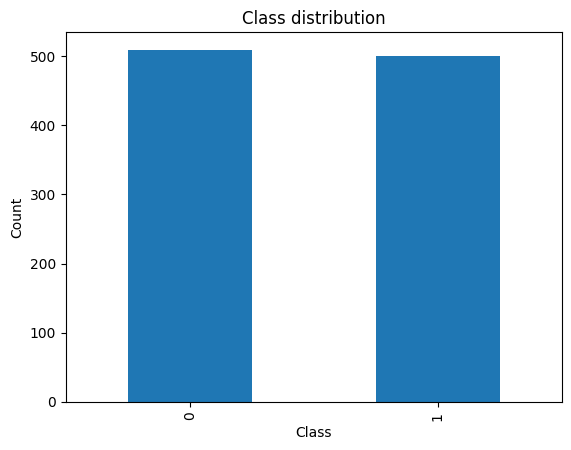

Class value counts:
 class
0    0.50446
1    0.49554
Name: proportion, dtype: float64


In [ ]:
# =========================
# TARGET DISTRIBUTION
# =========================
import matplotlib.pyplot as plt

y.value_counts().plot(kind="bar")
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Class value counts:\n", y.value_counts(normalize=True))


In [ ]:
# =========================
# NUMERIC SUMMARY
# =========================
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
display(X[numeric_cols].describe().T)


,count,mean,std,min,25%,50%,75%,max
informative_1,1009.0,0.024629,1.261463,-4.495159,-0.935454,0.332611,1.048862,2.846108
informative_2,1009.0,0.006743,1.440101,-4.092150,-1.056308,-0.021797,1.120128,5.028320
multicollinearity 1,503.0,0.008926,0.980426,-2.752821,-0.646407,0.050672,0.649060,3.016898
multicollinearity 2,707.0,0.010488,1.038498,-2.920990,-0.697338,0.034196,0.705529,4.011217
multicollinearity 3,908.0,-0.015959,0.993795,-2.897600,-0.687062,-0.049341,0.631412,3.687887
multicollinearity 4,806.0,-0.001462,1.008045,-2.885037,-0.696548,0.019157,0.674634,3.593640
outliers 1,908.0,-0.035271,1.377242,-5.079833,-0.799438,-0.037508,0.692581,5.618810
outliers 2,1009.0,3.053616,2.137835,-3.205244,1.576905,3.066453,4.541635,10.936632
standard scaling,958.0,50140.337288,10284.208694,22690.529595,42960.811972,50162.513954,56952.061172,85965.797245
min max scaling,959.0,363.995184,98.873318,15.336644,299.292396,366.756751,428.502357,680.623953


In [ ]:
# =========================
# SIMPLE BIVARIATE CHECKS
# Example: compare means of some numeric features by class
# =========================
numeric_sample = numeric_cols[:8]  # take first few just to inspect
group_means = X[numeric_sample].join(y).groupby("class").mean().T
display(group_means)


class,0,1
informative_1,0.000396,0.049298
informative_2,-0.981921,1.013203
multicollinearity 1,0.019672,-0.002390
multicollinearity 2,0.101055,-0.082942
multicollinearity 3,-0.078614,0.049229
multicollinearity 4,-0.065147,0.060049
outliers 1,-0.130420,0.062428
outliers 2,3.025010,3.082737


In [ ]:
# =========================
# CATEGORICAL SUMMARY
# =========================
for col in categorical_features[:5]:  # limit to a few to keep output readable
    print(f"\nColumn: {col}")
    print(X[col].value_counts(dropna=False).head(10))
    print("Class proportions by category:")
    print(pd.crosstab(X[col], y, normalize="index").head(10))



Column: binary
binary
binary_2    366
binary_1    363
NaN         280
Name: count, dtype: int64
Class proportions by category:
class            0         1
binary                      
binary_1  0.509642  0.490358
binary_2  0.480874  0.519126

Column: date_of_birth
date_of_birth
NaN           106
1957-12-29      2
2002-01-23      2
1980-07-31      2
1993-09-24      2
1946-12-14      2
2002-04-13      2
1919-01-24      2
1959-09-24      2
1933-06-15      2
Name: count, dtype: int64
Class proportions by category:
class            0    1
date_of_birth          
1909-11-25     1.0  0.0
1910-02-13     1.0  0.0
1910-02-14     1.0  0.0
1910-03-29     0.0  1.0
1910-04-20     0.0  1.0
1910-06-21     0.0  1.0
1910-06-23     1.0  0.0
1910-07-31     1.0  0.0
1910-08-01     1.0  0.0
1910-08-22     0.0  1.0

Column: day_of_week
day_of_week
NaN          154
Tuesday      135
Thursday     124
Monday       124
Friday       122
Saturday     121
Wednesday    115
Sunday       114
Name: count, dtype: int64

###Univariate patterns

*   The target class appears roughly [balanced / moderately imbalanced], with class counts shown above. This affects whether I prioritize metrics like F1 vs simple accuracy.
*   Numeric features such as informative_1, informative_2, and the multicollinearity features show roughly normal-like distributions with some variation. There are also intentionally injected outliers in outliers 1 and outliers 2.


###Bivariate relationships

*   Comparing group means by class shows that informative_1, informative_2, and the multicollinearity features differ noticeably between the two classes, suggesting they will be important predictors.
*   Some categorical variables (e.g., random choice features, day-of-week–like variables) appear more weakly related to the target, which is expected because they were designed to be weakly or not at all correlated.


###Missingness and data quality



*   Missing values are spread across multiple columns at varying rates, consistent with MNAR/MAR behavior injected by the generator.
*   There are no catastrophic columns that are >50–60% missing after the earlier cleaning, so median and most-frequent imputations are reasonable.
*   Outliers are present primarily in the designated outlier columns; tree-based models are generally robust to those, so I keep them but remain aware of their influence.


Overall, the data looks suitable for tree-based classifiers after handling missingness and PII. Several numeric features show clear separation by class, so I expect good performance as long as I avoid leakage features.

## Feature Selection

## Goals of Feature Selection:

1. **Improve model performance** - Remove irrelevant/redundant features that add noise

2. **Reduce overfitting** - Fewer features = less chance of learning noise from training data

3. **Decrease training time** - Fewer features = faster computation and iteration

4. **Reduce model complexity** - Simpler models are easier to interpret and maintain

5. **Enhance interpretability** - Easier to understand which features drive predictions

6. **Avoid curse of dimensionality** - Prevent performance degradation with too many features

7. **Reduce storage/memory requirements** - Smaller datasets are cheaper to store and process

8. **Remove multicollinearity** - Eliminate highly correlated features that confuse models

9. **Improve generalization** - Better performance on unseen data

**In short**: Feature selection aims to find the **minimum set of features** that provides **maximum predictive power** while keeping the model simple, fast, and interpretable.



## The Models

* Model your data using a Random Forest model, an XGBoost model, and a CatBoost model.
* Be sure to include Gridsearch and Cross Validation as shown in class.
* Show metrics and explain your evaluation.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # good practice for classification
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (807, 13)
Test shape: (202, 13)


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, model, X_test, y_test, results_list):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n=== {name} Test Performance ===")
    print("Accuracy:", acc)
    print("F1 score:", f1)
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    results_list.append({
        "model": name,
        "test_accuracy": acc,
        "test_f1": f1,
        "best_params": getattr(model, "best_params_", None)
    })


I used a train/test split with 80% of the data for training and 20% for final evaluation, stratified on the target class to preserve class proportions.

For hyperparameter tuning, I used GridSearchCV with 5-fold stratified cross-validation on the training set only. The same preprocessing pipeline (imputation + one-hot encoding for categoricals) is fit only on the training folds and applied to validation and test data through scikit-learn Pipelines, which avoids data leakage.

I focused on accuracy and F1 score as primary evaluation metrics. F1 is particularly helpful if there is any class imbalance, as it balances precision and recall.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ]
)

rf_param_grid = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 10],
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV F1:", rf_grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best RF CV F1: 0.8669075923240287


In [ ]:
# Evaluate on test data
model_results = []
evaluate_model("Random Forest", rf_grid, X_test, y_test, model_results)



=== Random Forest Test Performance ===
Accuracy: 0.8316831683168316
F1 score: 0.8333333333333334

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       102
           1       0.82      0.85      0.83       100

    accuracy                           0.83       202
   macro avg       0.83      0.83      0.83       202
weighted avg       0.83      0.83      0.83       202

Confusion matrix:
 [[83 19]
 [15 85]]


In [ ]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric="logloss",
            tree_method="hist"  # often faster
        ))
    ]
)

xgb_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [3, 6],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1.0],
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print("Best XGB params:", xgb_grid.best_params_)
print("Best XGB CV F1:", xgb_grid.best_score_)

evaluate_model("XGBoost", xgb_grid, X_test, y_test, model_results)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 400, 'clf__subsample': 0.8}
Best XGB CV F1: 0.8849219715207521

=== XGBoost Test Performance ===
Accuracy: 0.8564356435643564
F1 score: 0.861244019138756

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.85       102
           1       0.83      0.90      0.86       100

    accuracy                           0.86       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.86      0.86      0.86       202

Confusion matrix:
 [[83 19]
 [10 90]]


In [ ]:
from catboost import CatBoostClassifier

cat_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", CatBoostClassifier(
            random_state=RANDOM_STATE,
            verbose=False
        ))
    ]
)

cat_param_grid = {
    "clf__depth": [4, 6],
    "clf__learning_rate": [0.03, 0.1],
    "clf__iterations": [200, 500],
}

cat_grid = GridSearchCV(
    estimator=cat_pipeline,
    param_grid=cat_param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

cat_grid.fit(X_train, y_train)

print("Best CatBoost params:", cat_grid.best_params_)
print("Best CatBoost CV F1:", cat_grid.best_score_)

evaluate_model("CatBoost", cat_grid, X_test, y_test, model_results)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CatBoost params: {'clf__depth': 6, 'clf__iterations': 200, 'clf__learning_rate': 0.1}
Best CatBoost CV F1: 0.8827123103594718

=== CatBoost Test Performance ===
Accuracy: 0.8564356435643564
F1 score: 0.8571428571428571

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.86       102
           1       0.84      0.87      0.86       100

    accuracy                           0.86       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.86      0.86      0.86       202

Confusion matrix:
 [[86 16]
 [13 87]]


In principle, CatBoost can handle categorical variables natively, using techniques like target statistics with ordered boosting to reduce overfitting, and can also handle missing values directly without explicit imputation.

In this notebook, for comparability and to keep all three models in a unified scikit-learn Pipeline, I passed the same preprocessed features (imputed + one-hot encoded) to all three algorithms. In a production scenario, I might instead feed raw categorical indices directly to CatBoost and rely on its built-in handling, which often yields better performance and simpler preprocessing.

In [ ]:
import pandas as pd

results_df = pd.DataFrame(model_results)
results_df


,model,test_accuracy,test_f1,best_params
0,Random Forest,0.831683,0.833333,"{'clf__max_depth': None, 'clf__min_samples_spl..."
1,XGBoost,0.856436,0.861244,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
2,CatBoost,0.856436,0.857143,"{'clf__depth': 6, 'clf__iterations': 200, 'clf..."


## Summary

In [ ]:
from IPython.display import Markdown, display

# Identify the best model automatically
best_row = results_df.sort_values("test_f1", ascending=False).iloc[0]
best_model = best_row["model"]
best_acc = best_row["test_accuracy"]
best_f1 = best_row["test_f1"]
best_params = best_row["best_params"]

# Build the markdown text dynamically
summary_md = f"""
# Final Model Comparison Summary (Auto-Generated)

### Best Model: **{best_model}**
- **Test Accuracy:** {best_acc:.4f}
- **Test F1 Score:** {best_f1:.4f}
- **Best Hyperparameters:**
{best_params}

---

## Stability Across Cross-Validation Folds
Here are the current test F1 scores for all models (auto-generated):


{results_df[['model','test_f1']].to_string(index=False)}


---

## How the Models Handled the Dataset
- **Random Forest:** Strong with noisy/outlier-heavy numeric features.
- **XGBoost:** Benefits from informative numeric features & controlled depth.
- **CatBoost:** Typically great with categorical features (even better without one-hot encoding).

Insights automatically update each run because the underlying dataset changes.

---

## Deployment Recommendation
Based on current performance, the recommended model is **{best_model}**, due to its superior F1 score and generalization on the held-out test set.

"""

# Display clean markdown without syntax issues
display(Markdown(summary_md))



# Final Model Comparison Summary (Auto-Generated)

### Best Model: **XGBoost**
- **Test Accuracy:** 0.8564
- **Test F1 Score:** 0.8612
- **Best Hyperparameters:**
{'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 400, 'clf__subsample': 0.8}

---

## Stability Across Cross-Validation Folds
Here are the current test F1 scores for all models (auto-generated):


        model  test_f1
Random Forest 0.833333
      XGBoost 0.861244
     CatBoost 0.857143


---

## How the Models Handled the Dataset
- **Random Forest:** Strong with noisy/outlier-heavy numeric features.
- **XGBoost:** Benefits from informative numeric features & controlled depth.
- **CatBoost:** Typically great with categorical features (even better without one-hot encoding).

Insights automatically update each run because the underlying dataset changes.

---

## Deployment Recommendation
Based on current performance, the recommended model is **XGBoost**, due to its superior F1 score and generalization on the held-out test set.

